# 02. 확률적 프로그래밍 (Probabilistic Programming Language, PPL)
- 전자상거래 사이트에서 사용자별 구입 점수를 최대화하고자 하는 경우, 혹은 사용자의 체류 시간을 최대화하고자 하는 경우,
    
    데이터가 0 이상의 점수 (실수)로 표현

    $\rightarrow$ 최적화 대상이 바뀔 때마다 새로 계산을 진행하는 것은 부담
    
<br>

- 데이터가 생성되는 과정을 통계모델의 형태로 기술함으로써 구체적인 문제를 추상화하고, 다른 대상 및 컴퓨터와 공유
- 통계모델을 확률적 프로그래밍 언어 (PPL)로 기술하여, 사후분포를 추론해 다양한 통계량을 계산

    $\rightarrow$ 분석가는 미리 구체적인 계산에 관해 생각하지 않고, 직면한 문제를 통계 모델로 변환하는 데 집중
    
    

<br>

## 02.01. 통계모델 기술과 샘플링

- ㄱ와 ㄴ의 보고서

| ㄱ의 보고서 | A안 |B안 |
| - | - | -  |
| 노출수 | 40 | 50|
| 클릭수 | 2 | 4 |
| 클릭률 | 5% | 8% |

<br>

| ㄴ의 보고서 | A안 |B안 |
| - | - | -  |
| 노출수 | 1280 | 1600|
| 클릭수 | 64 | 128 |
| 클릭률 | 5% | 8% |


In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm

- ㄱ의 A안에 대한 노출수, 클릭수

In [3]:
N = 40  
a = 2  

<br>

### MCMC (Markov Chain Monte-Carlo, 마르코프 연쇄 몬테카를로 알고리즘)
- 대량의 난수를 생ㅅ헝하여 문제를 해결하는 시뮬레이션 기법
- Markov Chain은 이산적인 시간과 함께 점점 상태가 변화하는 과정을 의미하며, 미래상태는 현재 상태에 대해서만 규정된다는 특성 (마르코프 특성)을 가짐

<br>


- **통계모델 객체 생성**
    - `pm.Uniform` : 균일사전분포. 이항 가능도 확률변수 $\theta$가 존재하는 범위 = $0 \leq \theta \leq 1$
    - `pm.Binomial`: 관측값에 대한 이항분포 (이항 가능도) 

<br>

- **`pm.sample` : 사후분포에 대한 추론**
    - 통계모델 객체의 사후분포로부터 샘플추출 
    - **사후분포로부터 랜덤샘플을 5,000개씩 2번 (`chains`) 생성 $\rightarrow$ 10,000개의 사후분포 랜덤샘플**

        한번의 랜덤샘플링당 5,000개의 랜덤샘플을 추출하도록 하였지만, 총 6,000개의 랜덤샘플이 2번씩 생성됨을 확인 
        
        $\rightarrow$ **MCMC는 어떤 초깃값으로부터 최적의 파라미터 주위를 맴돌도록 상태를 전이시키지만, 그 초깃값은 무작위로 설정되기 때문에, 최적의 파라미터와 상당이 떨어져 있는 값이 설정될 가능성이 높음**
        
        $\rightarrow$ **탐색 초깃값의 영향을 제거하기 위해 샘플을 버리는 기간 = Burn-In**
        
        $\rightarrow$ **1,000개의 샘플은 Burn-In 기간에 생성된 샘플**

In [6]:
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1) 
  # theta = pm.Beta('theta', alpha=1, beta=1)
    
  obs = pm.Binomial('a', p=theta, n=N, observed=a)
  trace = pm.sample(5000, chains=2)

C:\Users\FORYOUCOM\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 14 seconds.


- **MCMC를 통하여 얻은 사후분포 샘플**
    - 샘플의 분포 (사후분포) 
    - 샘플의 샘플링 횟수에 따른 궤적 : 샘플의 궤적이 어떤 구역을 중심으로 퍼져 있다면 일정 분포 상에서 샘플이 얻어졌음을 알 수 있음

C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_11652\2791953706.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


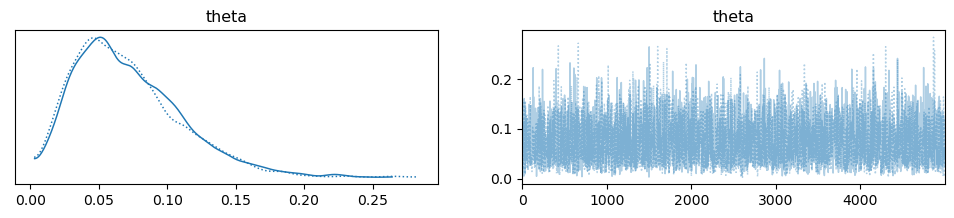

In [5]:
with model:
  pm.traceplot(trace)

- 사후분포의 요약 통계량

In [10]:
with model:
    print(pm.summary(trace, hdi_prob=0.95))

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta  0.071  0.039     0.008       0.15      0.001      0.0    3908.0   

       ess_tail  r_hat  
theta    4027.0    1.0  


- 사후분포를 요약 통계량과 함께 시각화

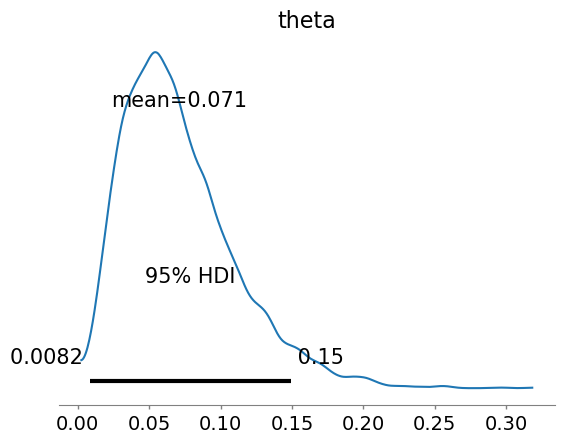

In [11]:
with model:
    pm.plot_posterior(trace, hdi_prob=0.95)

<br>

#### 사후분포에 대한 가설검정

> **가설 : ㄱ의 디자인 A안의 클릭률은 1% 이상**


$$\delta = \theta - 0.01\text{인 샘플이 95% 확률로 양수}$$

<br>

- **양수인 $\delta$의 비율은 전체 샘플중 99.24% $\rightarrow$ 가설 채택**

In [14]:
np.mean(trace['theta'] - 0.01 > 0.)

0.9924

<br>

- ㄱ의 B안에 대한 검정

In [15]:
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=2)
  obs = pm.Binomial('obs', p=theta, n=[40, 50], observed=[2, 4])
  trace = pm.sample(5000, chains=2)

C:\Users\FORYOUCOM\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 17 seconds.


- A안과 B안의 사후분포샘플

C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_11652\1331140333.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, ['theta'], compact=True)


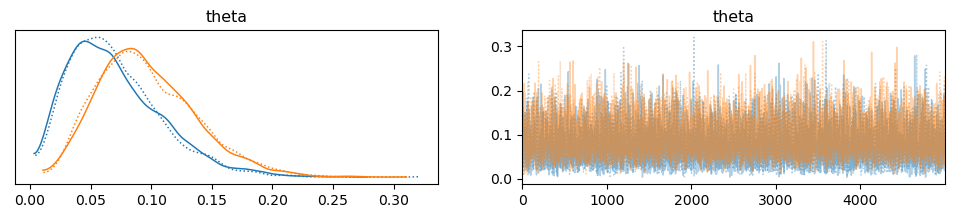

In [16]:
with model:
    pm.traceplot(trace, ['theta'], compact=True)

<br>

> **가설 : B안의 클릭률은 A안의 클릭률보다 높다**

$$\delta = \theta_B - \theta_A\text{의 샘플이 95% 확률로 양수}$$

<br>

- **양수인 $\delta$의 비율은 전체 샘플중 69.04% $\rightarrow$ 가설 기각**

In [17]:
np.mean(trace['theta'][:, 1] - trace['theta'][:, 0] > 0)

0.6903

<br>

- ㄴ의 보고서에 대한 가설검정

In [18]:
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=2)
  obs = pm.Binomial('obs', p=theta, n=[1280, 1600], observed=[64, 128]) 
  trace = pm.sample(5000, chains=2)

C:\Users\FORYOUCOM\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 17 seconds.


- ㄴ의 A안과 B안의 클릭률 사후분포 샘플

0.9989


C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_11652\3462492410.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, ['theta'], compact=True)


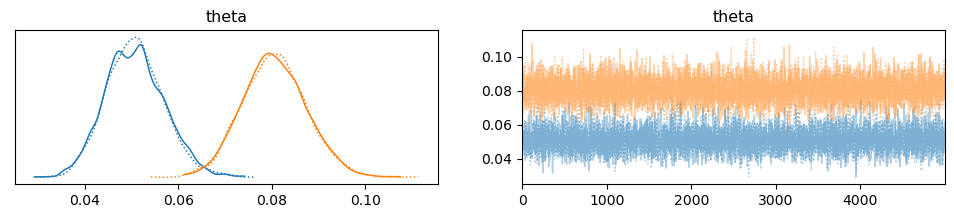

In [23]:
with model:
    print(np.mean(trace['theta'][:, 0] < trace['theta'][:, 1]))
    pm.traceplot(trace, ['theta'], compact=True)  

<br>

## 02.02. 리뷰 점수 (Review Score)
- 전자상거래 사이트 등에서는 사용자들이 매긴 상품 점수를 제공하며, 사용자의 소비 행동에 큰 영향
- 하지만 리뷰 점수에는 스팸처럼 불순한 의도로 매겨진 점수가 포함되었을 수도 있음

    $\rightarrow$ **리뷰의 수가 많을수록 리뷰 점수에 대한 부정적인 요인이 상쇄됨으로써 그 평균의 신뢰도가 높아짐**

    $\rightarrow$ **리뷰의 수가 적을수록, 소수 사용자의 의견이 과도하게 반영되어, 신뢰성이 낮아짐**

<br>

#### 제품에 대한 리뷰
- 두 제품 모두 평균 4.2점 정도의 높은 점수
- 그러나 평균 점수를 만든 사람의 수에는 큰 차이가 존재


| 제품 | 1점 | 2점 | 3점 | 4점 | 5점 | 리뷰자 수 합계 | 평균 점수 |
| - | - | - | - | - | - | - | - |
| A | 20 | 10 | 36 | 91 | 170 | 217 | 4.17| 
| B | 0 | 0 | 4 | 0 | 6 | 10 | 4.20 |

<br>

- 제품 안에는 각 리뷰점수가 생성될 확률 $\theta$가 들어있지만, 분석가는 그 확률을 알 수 없음
- 분석가는 관측된 데이터와, 확률에 대한 신념 $p(\theta)$

$$\theta = (\theta_1, \theta_2, \theta_3, \theta_4, \theta_5)$$

- **점수에 대한 확률 분포는 복수의 카테고리의 이산값을 출력하는 확률 분포 (Categorical Distribution)**

<br>

- **범주형 분포는 2개 이상의 범주를 다룰 수 있도록, 베르누이 분포를 확장한 것**

    $\rightarrow$ **이에 대한 사전분포는, 베르누이 분포의 공역 사전분포인 베타분포를 2개 이상의 범주를 다루는 경우로 확장한 확률형 분포**
    
    $\rightarrow$ **디리클레 분포 (Dirichlet Distribution)**
    
<br>

#### 디리클레 분포 (Dirichlet Distribution)
- **디리클레 분포는 연속 확률 분포의 하나로 $K$개의 확률변수 집합 $\theta$가 따르는 확률분포**
- **단, $\theta$의 각 요소는 0 이상 1 이하의 값이며, 그 합은 1**

    $\rightarrow$ **즉, 디리클레 분포를 따르는 확률변수 자체가 확률질량함수의 조건을 만족**
    
<br>

- **디리클레 분포는 집중도라고 불리는 $K$크기의 $\alpha$를 파라미터로 가지며, 각 요소는 양의 실수로 표현**
- **집중도 파라미터의 값이 모두 1일 때, 복수 범주에 대한 균일분포에 해당**

$$\theta \sim Dirichlet(\alpha = (1, 1, 1, 1, 1))$$
$$Obs \sim Categorical(\theta)$$

<br>

#### 디리클레 사전분포 기반 베이즈 추론 

- **상품 A의 평점에 대한 모델객체 생성**
    - **`pm.Dirichlet` : 디리클레 사전분포 (균등분포)**
    - **`pm.Categorical` : 관측값에 대한 다항 가능도**
    

In [24]:
n_a = [20, 10, 36, 91, 170]
data = [0 for _ in range(n_a[0])] 
data += [1 for _ in range(n_a[1])] 
data += [2 for _ in range(n_a[2])] 
data += [3 for _ in range(n_a[3])] 
data += [4 for _ in range(n_a[4])]

In [31]:
pd.DataFrame({'obs':data}).groupby('obs').agg(cnt=('obs', 'count'))

,cnt
obs,
0,20
1,10
2,36
3,91
4,170


In [25]:
with pm.Model() as model_a:
  theta = pm.Dirichlet('theta', a=np.array([1, 1, 1, 1, 1]))
  obs = pm.Categorical('obs', p=theta, observed=data)
  trace_a = pm.sample(5000, chains=2)

C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 243 seconds.


- 5가지 확률변수 ($\theta_1 \dots \theta_5$)에 대한 사후분포 샘플


C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_11652\2643979153.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_a)


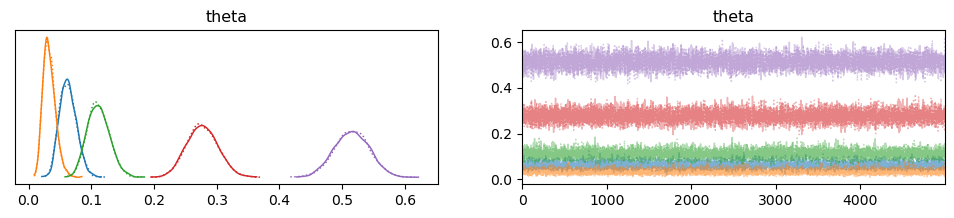

In [32]:
with model_a:
  pm.traceplot(trace_a)  

- **$\theta_0$, $\theta_1$의 분포는 0.1 이하의 영역에 존재**

    $\rightarrow$ **A에 대해 리뷰 점수 1점이나 2점이 매겨질 확률이 낮음**
    
- **$\theta_4$의 분포는 95% HDI가 0.5 주변에 존재  $\rightarrow$ A는 약 50%의 확률로 5점을 받을 수 있음**

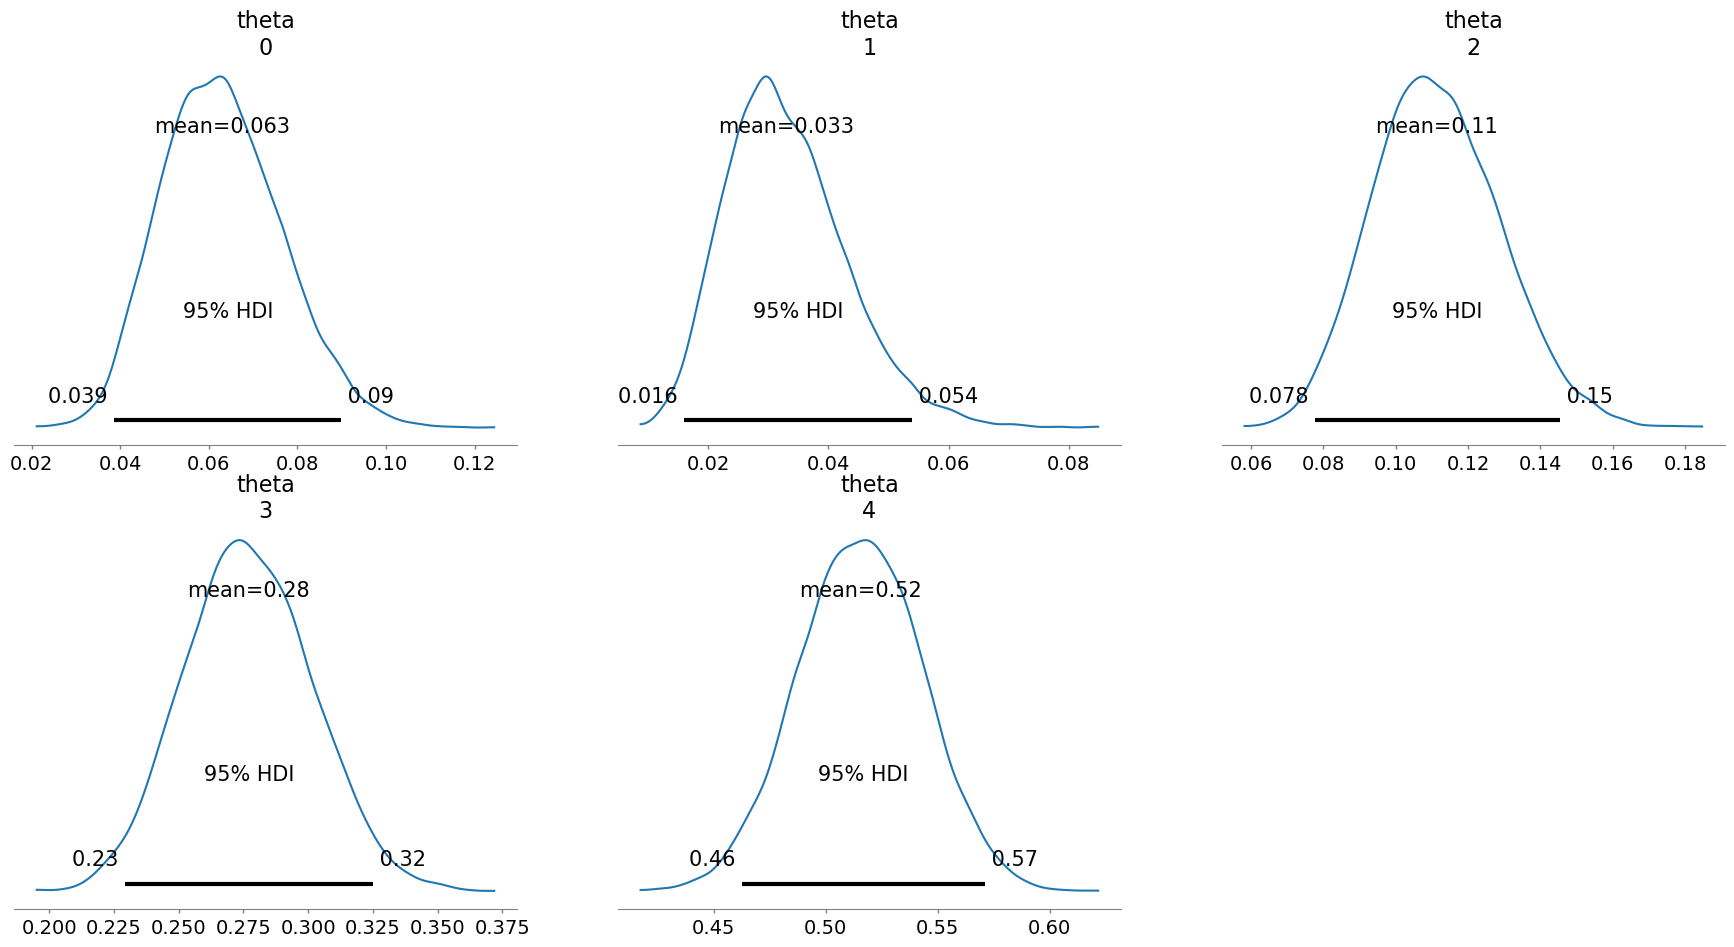

In [33]:
with model_a:
  pm.plot_posterior(trace_a, hdi_prob=0.95)  

<br>

- **A의 평점에 대한 기댓값 $m$** : 각 점수와, 각 점수가 나올 확률에 대한 가중평균

$$m = 1\times \theta_1 + 2\times \theta_2 + 3\times \theta_3 + 4\times \theta_4 + 5\times \theta_5$$

In [34]:
weights = np.array([1, 2, 3, 4, 5])
m_a = [sum(row * weights) for row in trace_a['theta']]

- $m$의 샘플분포
- A의 평균 리뷰점수는 4.0 ~ 4.3 사이의 좁은 구간에 집중된 형태
    - 4.0보다 큰 $m$의 표본은 98.92% $\rightarrow$ 우연이라는 요소가 포함되었다 해도 적어도 4.0점보다는 높다고 말할 수 있음
    
    

In [45]:
np.mean([m > 4.0 for m in m_a])

0.9892

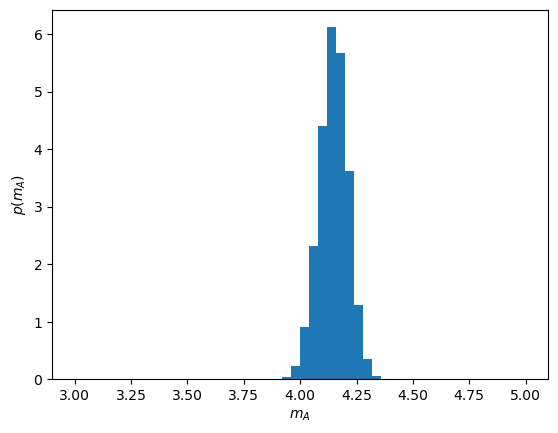

In [37]:
plt.hist(m_a, range=(3, 5), bins=50, density=True)
plt.xlabel(r'$m_A$')
plt.ylabel(r'$p(m_A)$')
plt.show() 

<br>

- **상품 B의 평균평점 분포**

C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 78 seconds.
C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_11652\3718549929.py:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_b)


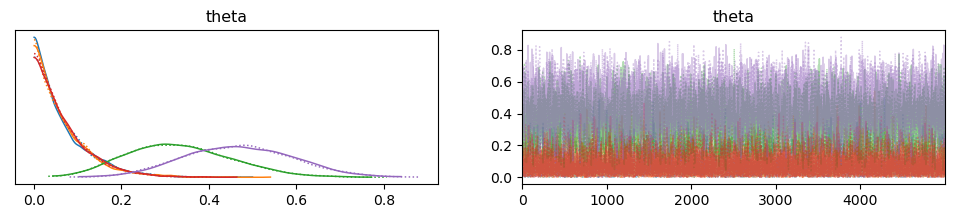

In [46]:
n_b = np.array([0, 0, 4, 0, 6]) 

with pm.Model() as model_b:
  theta = pm.Dirichlet('theta', a=np.array([1, 1, 1, 1, 1]))
  obs = pm.Multinomial('obs', p=theta, n=n_b.sum(), observed=n_b)
  trace_b = pm.sample(5000, chains=2)
  
  pm.traceplot(trace_b) 

- **B의 평균평점 분포가, A와 비교해 폭이 더 넓음**

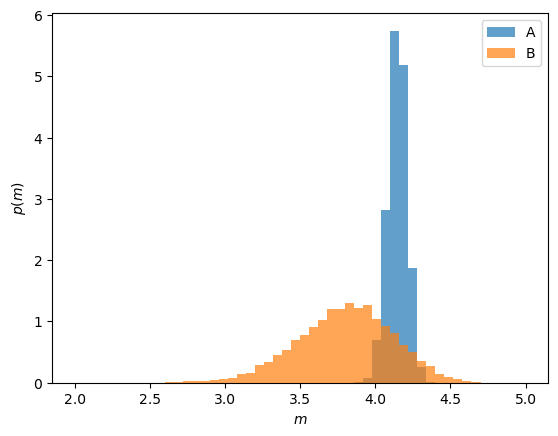

In [47]:
m_b = [sum(row * weights) for row in trace_b['theta']] 
plt.hist(m_a, range=(2, 5), bins=50, density=True, label='A', alpha=0.7)
plt.hist(m_b, range=(2, 5), bins=50, density=True, label='B', alpha=0.7)
plt.xlabel(r'$m$')
plt.ylabel(r'$p(m)$')
plt.legend()
plt.show() 

<br>

## 02.03. 체류시간
- 사용자가 특정 웹사이트에 머문 후 초단위의 시간이나 화면의 표시 영역에 들어온 웹사이트의 콘텐츠 비율 등의 지표는 연속값

In [48]:
import urllib

In [50]:
url = 'https://www.oreilly.co.jp/pub/9784873119168/data/time-on-page.csv'
response = urllib.request.urlopen(url)
data = [int(row.strip()) for row in response.readlines()]

In [54]:
data[:5]

[20, 178, 4, 112, 576]

- 대부분의 사용자는 짧은 시간 안에 웹사이트를 벗어나며, 극히 적은 사용자만 오랜 기간 머뭄

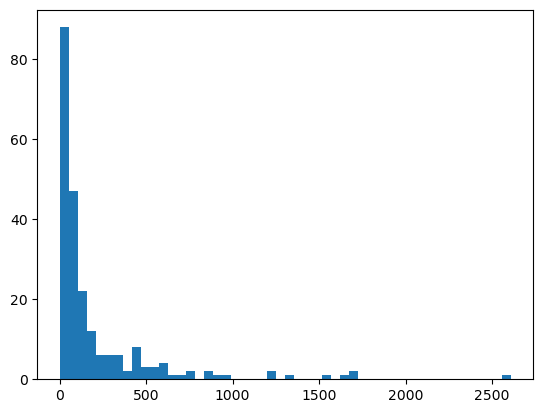

In [51]:
plt.hist(data, bins=50)
plt.show() 

<br>

#### 지수분포 (Exponential Distribution)
- **일정한 확률로 발생하는 이벤트의 시간 간격을 다루는데 자주 사용되는 분포**

<br>

- **사용자가 웹사이트로부터 이탈하는 것을 매초마다 일정한 확률로 발생하는 이벤트라고 생각하면,**
    
    $\rightarrow$ **체류시간 $t$은 시간간격 $\rightarrow$ $t$에 대한 지수 가능도**
    

<br>

$$p(x|\theta) = \frac{e^{-x / \theta}}{\theta}$$

- **지수분포는 양의 연속값에 관한 확률 분포이며, 양의 실수로 표현되는 척도 파라미터 (Scale Parameter) $\theta > 0$을 가짐**
- 지수분포의 기댓값은 $\theta$, 분산은 $\theta^2$

<br>

#### 균등 사전분포 적용
- 지수 가능도의 파라미터 $\theta$는 양의 실수이므로

$$\theta \sim Uniform(0, 3000)$$

$$t \sim Exponential(\theta)$$

- `pm.Exponential` : 관측값에 대한 지수 가능도

<br>

- 사후분포 샘플

C:\Users\FORYOUCOM\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 38 seconds.
C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_11652\2671641734.py:5: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


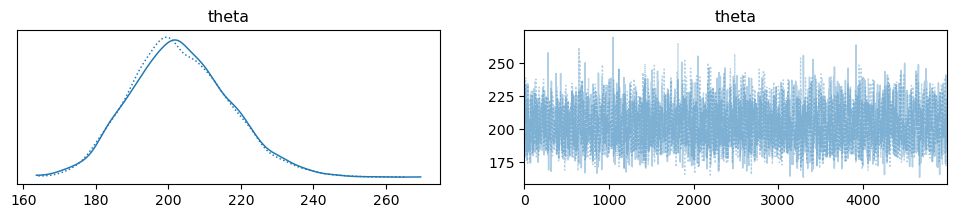

In [55]:
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=3000)
  obs = pm.Exponential('obs', lam=1/theta, observed=data) 
  trace = pm.sample(5000, chains=2)

  pm.traceplot(trace) 

- **지수분포의 기댓값은 $\theta$**
    
    $\rightarrow$ **$\theta$의 사후분포의 기댓값이 그대로 체류시간 $t$의 기댓값**
    
- 대부분의 사용자가 178초에서 232초 사이에 이탈

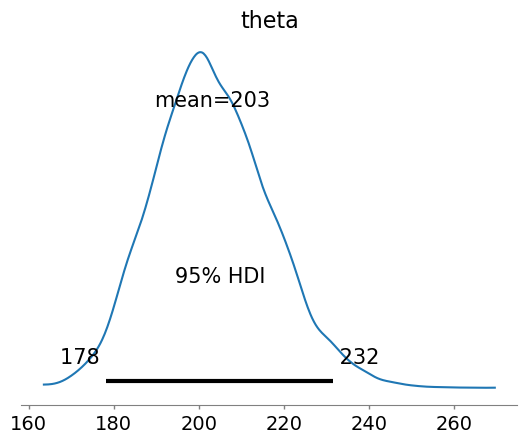

In [56]:
with model:
  pm.plot_posterior(trace, hdi_prob=0.95)  

<br>

## 02.04. NHST vs 베이즈 접근

<br>

#### NHST (Null Hypothesis Significance Testing, 귀무가설 유의성 검정)
- 베이즈 추론을 이용하지 않는 통계적 가설검정 
- 귀무가설 (Null) vs 대립가설 (Alternative)
- 다음과 같은 귀류법 (배리법)에 기반하여 가설 검정의 논의를 진행
     1. 어떤 통계량이 어떤 값과 같다는 것을 귀무가설로 설정
     2. 귀무가설이 성립할 때 그 통계량 (검정통계량)이 따르는 확률분포인 표본분포 (Sampling Dist)를 계산
     3. 실제 관측된 값 또는 그 이상의 극단적인 값이 표본분포에서 차지하는 넓이, 즉 그 값이 관측될 확률을 계산)
     4. 구한 확률이 미리 설정해놓은 유의수준보다 작아지면, 설정한 귀무가설이 틀렸다는 결론
 
 
<br>
 
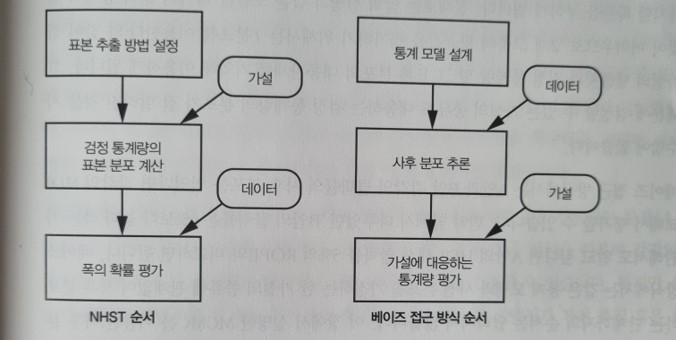

<br>

#### 베이즈 접근의 이점
- NHST에서는 가설설정이 가설검정 프로세서의 앞쪽에 위치 
    
    $\rightarrow$ 먼저 설정된 귀무가설에 기반하여 검정 통계량의 표준 분포를 계산한 뒤,
    
    $\rightarrow$ 관측된 데이터를 입수하여 판단
    
    $\rightarrow$ 가설에 따라 대응하는 검정 통계량이 달라지기 때문에, 초반부터 구체적인 검정의 방향이 나뉘어짐
    
<br>

- **베이즈 접근 방식은 가설설정이 가설거정 프로세스의 뒤쪽에 위치**

    $\rightarrow$ **데이터와 통계모델과 베이즈 추론을 통하여 파라미터의 사후분포를 계산하고,**
    
    $\rightarrow$ **그 결과로부터 관심있는 통계량을 계산하여 판단**
    
    $\rightarrow$ **검정하고자 하는 가설에 관계없이 사후분포를 구하는 부분 까지의 순서가 불변**
    
    $\rightarrow$ **가설검정에 높은 자유도가 존재**